You can also read information about the results and a description of the data in the README file.

# lib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
import joblib
import os
from tqdm.notebook import tqdm 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


from prophet import Prophet

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import lightgbm as lgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


from pycaret.time_series import TSForecastingExperiment

In [ ]:
def plot_forecast_generic(y_train, y_test, forecast_df, model_name="Model", 
                           show_anomalies=True, start_date=None, interval_confidence=True):
    """
    Universal forecast visualizer for both Prophet and ARIMA-like forecasts.
    """

    
    if 'ds' in forecast_df.columns:
        forecast_df = forecast_df.set_index('ds')
    if 'yhat' in forecast_df.columns:
        forecast_df.rename(columns={'yhat': 'y_pred'}, inplace=True)
    if 'yhat_upper' in forecast_df.columns:
        forecast_df.rename(columns={'yhat_upper': 'upper'}, inplace=True)
    if 'yhat_lower' in forecast_df.columns:
        forecast_df.rename(columns={'yhat_lower': 'lower'}, inplace=True)

    
    y_train.index = pd.to_datetime(y_train.index)
    y_test.index = pd.to_datetime(y_test.index)
    forecast_df.index = pd.to_datetime(forecast_df.index)

    
    forecast_df = forecast_df.reindex(y_test.index)
    forecast_df = forecast_df.dropna(subset=['y_pred'])
    y_pred = forecast_df['y_pred']

    
    mae = mean_absolute_error(y_test.loc[y_pred.index], y_pred)
    mape = mean_absolute_percentage_error(y_test.loc[y_pred.index], y_pred) * 100
    rmse = np.sqrt(mean_squared_error(y_test.loc[y_pred.index], y_pred))

    
    if start_date is not None:
        start_date = pd.to_datetime(start_date)
        y_train = y_train.loc[y_train.index >= start_date]
        y_test = y_test.loc[y_test.index >= start_date]
        forecast_df = forecast_df.loc[forecast_df.index >= start_date]

    fig = go.Figure()

    
    fig.add_trace(go.Scatter(
        x=y_train.index, y=y_train.values,
        mode='lines', name='Train', line=dict(color='gray', dash='dot')
    ))

    
    fig.add_trace(go.Scatter(
        x=y_test.index, y=y_test.values,
        mode='lines', name='Actual (Test)', line=dict(color='green')
    ))

    
    fig.add_trace(go.Scatter(
        x=forecast_df.index, y=forecast_df['y_pred'],
        mode='lines', name='Prediction', line=dict(color='blue')
    ))

    
    if interval_confidence and 'upper' in forecast_df.columns and 'lower' in forecast_df.columns:
        fig.add_trace(go.Scatter(
            x=forecast_df.index, y=forecast_df['upper'],
            mode='lines', name='Upper Bound', line=dict(dash='dot', color='red'),
            showlegend=False
        ))
        fig.add_trace(go.Scatter(
            x=forecast_df.index, y=forecast_df['lower'],
            mode='lines', name='Lower Bound', line=dict(dash='dot', color='red'),
            fill='tonexty',
            fillcolor='rgba(255,0,0,0.1)',
            showlegend=True
        ))

    
    if show_anomalies:
        anomalies = (y_test.loc[y_pred.index] < forecast_df['lower']) | (y_test.loc[y_pred.index] > forecast_df['upper'])
        if anomalies.any():
            anomaly_points = y_test.loc[y_pred.index][anomalies]
            errors = anomaly_points - forecast_df.loc[anomaly_points.index]['y_pred']

            fig.add_trace(go.Scatter(
                x=anomaly_points.index,
                y=anomaly_points.values,
                mode='markers',
                name='Anomalies',
                marker=dict(color='red', size=8, symbol='x'),
                customdata=[f"{error:.0f}" for error in errors],
                hovertemplate=(
                    "Date: %{x}<br>"
                    "Actual: %{y}<br>"
                    "Error: Δ=%{customdata}<extra></extra>"
                )
            ))

    
    fig.update_layout(
        title=f"{model_name} — MAPE: {mape:.2f}%, MAE: {mae:.0f}, RMSE: {rmse:.0f}",
        xaxis_title="Date",
        yaxis_title="Sales",
        template='plotly_white',
        height=500
    )

    return fig


def plot_grouped_data(data_train, data_test, grouped_parameter,description = 'description' ):

    data_train = data_train.rename(columns={'month':'Date'})
    data_test = data_test.rename(columns={'month':'Date'})

    # Dropdown for grouped feature 
    feature_selector = widgets.Dropdown(
    options=sorted(data_train[grouped_parameter].unique()),
    description=f'{description}:',
    layout=widgets.Layout(width='300px')
                                       )
    output = widgets.Output()

    def plot_for_feature(parameter_id):
        train_copy = data_train[data_train[grouped_parameter] == parameter_id].copy()
        train_copy = train_copy.rename(columns={'Date': 'ds', 'number_sold': 'y'})
    
        test_copy = data_test[data_test[grouped_parameter] == parameter_id].copy()
        test_copy = test_copy.set_index('Date')

        model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model_prophet.fit(train_copy)

        future = model_prophet.make_future_dataframe(periods=365)
        forecast = model_prophet.predict(future)

        fig = plot_forecast_generic(
            y_train=train_copy.set_index('ds')['y'],
            y_test=test_copy['number_sold'],
            forecast_df=forecast,
            model_name=f"Prophet — {description} {parameter_id}",
            start_date='2017-10-01'
                               )
        return fig
    
    def on_parameter_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            with output:
                clear_output(wait=True)
                fig = plot_for_feature(change['new'])
                fig.show()
    
    
    feature_selector.observe(on_parameter_change)


    display(feature_selector, output)

    with output:
        fig = plot_for_feature(feature_selector.value)
        fig.show()
    

# EDA 

In [ ]:
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

In [187]:
(train.shape, test.shape)

((230090, 4), (25550, 4))

In [188]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         230090 non-null  object
 1   store        230090 non-null  int64 
 2   product      230090 non-null  int64 
 3   number_sold  230090 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB


In [189]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25550 entries, 0 to 25549
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         25550 non-null  object
 1   store        25550 non-null  int64 
 2   product      25550 non-null  int64 
 3   number_sold  25550 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 798.6+ KB


In [190]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

train['year'] = train['Date'].dt.year
test['year'] = test['Date'].dt.year

train['week'] = train['Date'].dt.to_period('W').dt.start_time
test['week'] = test['Date'].dt.to_period('W').dt.start_time

train['month'] = train['Date'].dt.to_period('M').dt.start_time
test['month'] = test['Date'].dt.to_period('M').dt.start_time

In [191]:
def aggregate(df, time_col, group_col=None):
    if group_col:
        return df.groupby([time_col, group_col])['number_sold'].sum().reset_index()
    else:
        return df.groupby(time_col)['number_sold'].sum().reset_index()

In [192]:
# Total
daily_total_train   = aggregate(train, 'Date')
weekly_total_train  = aggregate(train, 'week')
monthly_total_train = aggregate(train, 'month')
yearly_total_train = aggregate(train,'year')

daily_total_test    = aggregate(test, 'Date')
weekly_total_test   = aggregate(test, 'week')
monthly_total_test  = aggregate(test, 'month')
yearly_total_test = aggregate(test,'year')

# Product-level
daily_product_train   = aggregate(train, 'Date', 'product')
weekly_product_train  = aggregate(train, 'week', 'product')
monthly_product_train = aggregate(train, 'month', 'product')
yearly_product_train = aggregate(train,'year','product')

daily_product_test    = aggregate(test, 'Date', 'product')
weekly_product_test   = aggregate(test, 'week', 'product')
monthly_product_test  = aggregate(test, 'month', 'product')
yearly_product_test = aggregate(test,'year','product')

# Store-level
daily_store_train   = aggregate(train, 'Date', 'store')
weekly_store_train  = aggregate(train, 'week', 'store')
monthly_store_train = aggregate(train, 'month', 'store')
yearly_store_train = aggregate(train, 'year', 'store')

daily_store_test    = aggregate(test, 'Date', 'store')
weekly_store_test   = aggregate(test, 'week', 'store')
monthly_store_test  = aggregate(test, 'month', 'store')
yearly_store_test = aggregate(test, 'year', 'store')

In [193]:
(train['store'].unique(), test['store'].unique())

(array([0, 1, 2, 3, 4, 5, 6]), array([0, 1, 2, 3, 4, 5, 6]))

In [11]:
(train['product'].unique(), test['product'].unique())

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [12]:
(train['Date'].min(), train['Date'].max())

(Timestamp('2010-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [13]:
(test['Date'].min(), test['Date'].max())

(Timestamp('2019-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [14]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Daily Sales", "Weekly Sales", "Monthly Sales", "Yearly Sales")
)

fig.add_trace(go.Scatter(
    x=daily_total_train['Date'],
    y=daily_total_train['number_sold'],
    mode='lines+markers',
    name='Daily Sales'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=weekly_total_train['week'],
    y=weekly_total_train['number_sold'],
    mode='lines+markers',
    name='Weekly Sales'
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=monthly_total_train['month'],
    y=monthly_total_train['number_sold'],
    mode='lines+markers',
    name='Monthly Sales'
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=yearly_total_train['year'],  
    y=yearly_total_train['number_sold'],
    mode='lines+markers',
    name='Yearly Sales'
), row=2, col=2)

fig.update_layout(
    height=700, width=1000,
    title_text="Sales Overview: Daily, Weekly, Monthly, Yearly",
    showlegend=False
)

fig.show()

- There is a clear seasonality — the cycles repeat approximately every year
- There is a slow growth: sales are gradually increasing from 2010 to 2018
- Oddities at the ends: sharp outliers at the beginning and at the end — these are probably incomplete weeks (for example, incomplete first/last year). It will be needed to delete
- There are almost no weekly fluctuations, and there is a lot of smoothness.
- The cyclicity is more pronounced than in the weekly: there is a regular drop about once every 12 months — it may be January (low demand).

Yearly 
- The growth from 2014 to 2018, especially since 2015, is almost exponential.
- Before 2014— stagnation or even a slight decline.
- The overall trend is upward, especially in the last 3 years.

In [15]:
weekly_total_train = weekly_total_train.iloc[1:-1].copy()

In [16]:

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Daily Sales", "Weekly Sales", "Monthly Sales", "Yearly Sales"),
    shared_yaxes=False
)

def add_traces(fig, df, x_col, row, col, name_suffix, group_object):
    for group_object_id in df[group_object].unique():
        subset = df[df[group_object] == group_object_id]
        fig.add_trace(go.Scatter(
            x=subset[x_col],
            y=subset['number_sold'],
            mode='lines',
            name=f'{group_object.capitalize()} {group_object_id}',  
            legendgroup=f'{group_object}_{group_object_id}',
            showlegend=(row == 1 and col == 1)  
        ), row=row, col=col)


add_traces(fig, daily_product_train, 'Date', 1, 1, 'Daily','product')
add_traces(fig, weekly_product_train, 'week', 1, 2, 'Weekly','product')
add_traces(fig, monthly_product_train, 'month', 2, 1, 'Monthly','product')
add_traces(fig, yearly_product_train, 'year', 2, 2, 'Yearly','product')


fig.update_layout(
    height=800,
    width=1100,
    title_text="Sales per Product — Daily / Weekly / Monthly / Yearly",
    legend_title="Products",
)

fig.show()

In [17]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Daily Sales", "Weekly Sales", "Monthly Sales", "Yearly Sales"),
    shared_yaxes=False
)

add_traces(fig, daily_store_train, 'Date', 1, 1, 'Daily', 'store')
add_traces(fig, weekly_store_train, 'week', 1, 2, 'Weekly', 'store')
add_traces(fig, monthly_store_train, 'month', 2, 1, 'Monthly', 'store')
add_traces(fig, yearly_store_train, 'year', 2, 2, 'Yearly', 'store')

fig.update_layout(
    height=800,
    width=1100,
    title_text="Sales per Stores — Daily / Weekly / Monthly / Yearly",
    legend_title="Store",
)

fig.show()

-  Trends by Product (Yearly Sales)
    - Products 0, 1, and 3 exhibit a local minimum around 2014, followed by a consistent upward trend in sales each year thereafter.
    - Products 2 and 5 began to grow in 2011 and have reached a plateau by 2016.
    - Products 4 and 6 show a gradual decline in sales starting from 2012.
    - Product 7 experienced growth until around 2012 and has since remained relatively stable.
    - Product 9 displays a steady and gradual increase in sales over the entire period.

- Trends by Store
    - Sales across all stores show only minor fluctuations, with no significant upward or downward trends observed.

# Model 


## Decompose into components (STL)

We decompose the time series into three components: trend, seasonality, and residuals. This allows us to analyze the structure of the time series and better understand its behavior. 

The additive model assumes that the components are combined by addition (i.e. total = trend + seasonality + noise).

With the multiplicative model, the components are combined by multiplication (i.e. total = trend × seasonality × noise)

The period is set to 365 to capture yearly seasonality.

In [18]:
adfuller(daily_total_train.set_index('Date')['number_sold'])
# p-value ≈ 0.108 — that is, there are no grounds for stationarity

(-2.532369713456418,
 0.10779573173599177,
 29,
 3257,
 {'1%': -3.4323593525669414,
  '5%': -2.8624278120183573,
  '10%': -2.567242601304915},
 38680.191029957496)

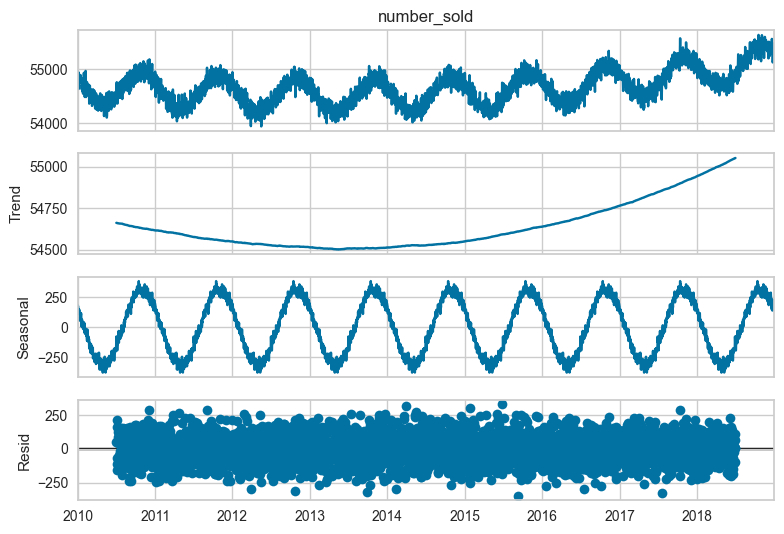

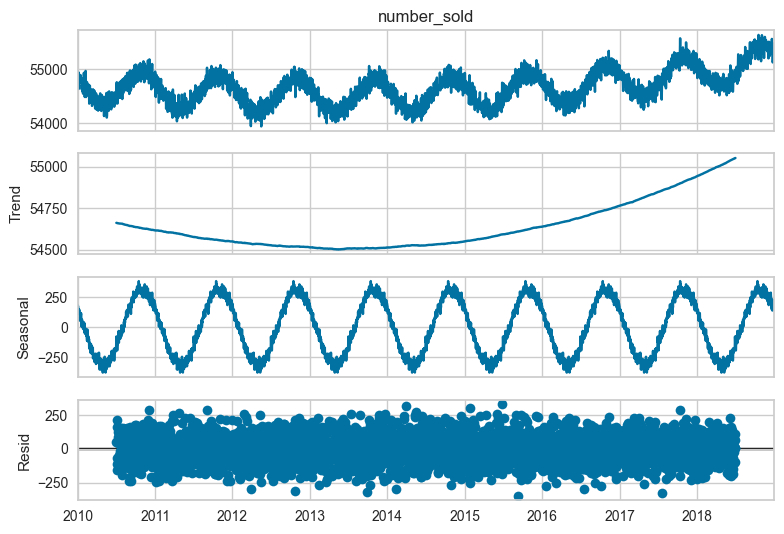

In [19]:
seasonal_decompose(daily_total_train.set_index('Date')['number_sold'],
                    model = 'additive', period = 365).plot()

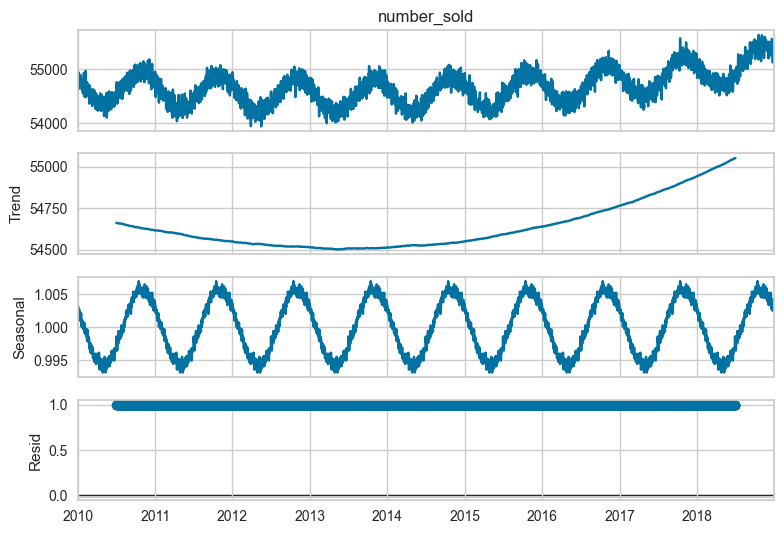

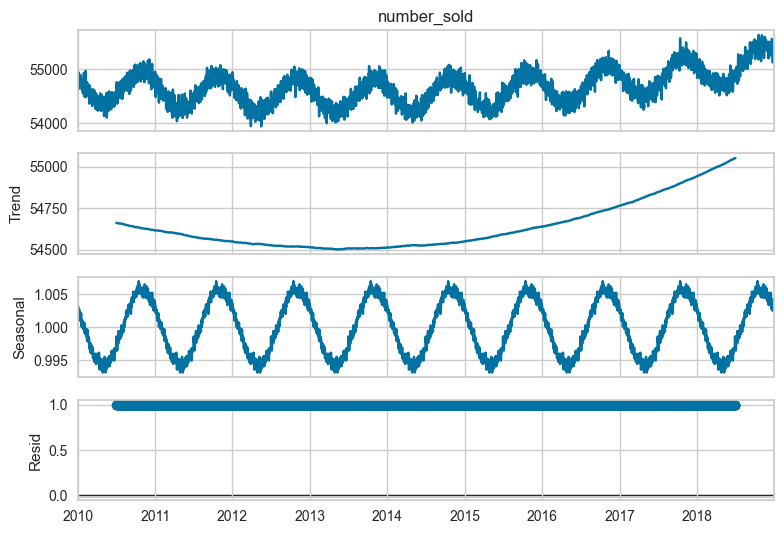

In [20]:
seasonal_decompose(daily_total_train.set_index('Date')['number_sold'],
                    model = 'multiplicative', period = 365).plot()

The additive decomposition, looks quite random which is good. So ideally, multiplicative decomposition should be preferred for this particular series.

## ACF and PACF

Next step is to plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) to analyze dependencies between observations at different time lags.

ACF shows how current values are correlated with past values at various lags. It helps to estimate the "q" parameter in ARIMA.

PACF shows the correlation of the current value with its past values, after removing the effects of intermediate lags. It helps to estimate the "p" parameter in ARIMA.

We set lags=60 to observe correlations up to 60 days back.

The 'ywm' method (Yule-Walker Modified) is used for PACF, which is stable and reliable for longer lags, especially for stationary time series.

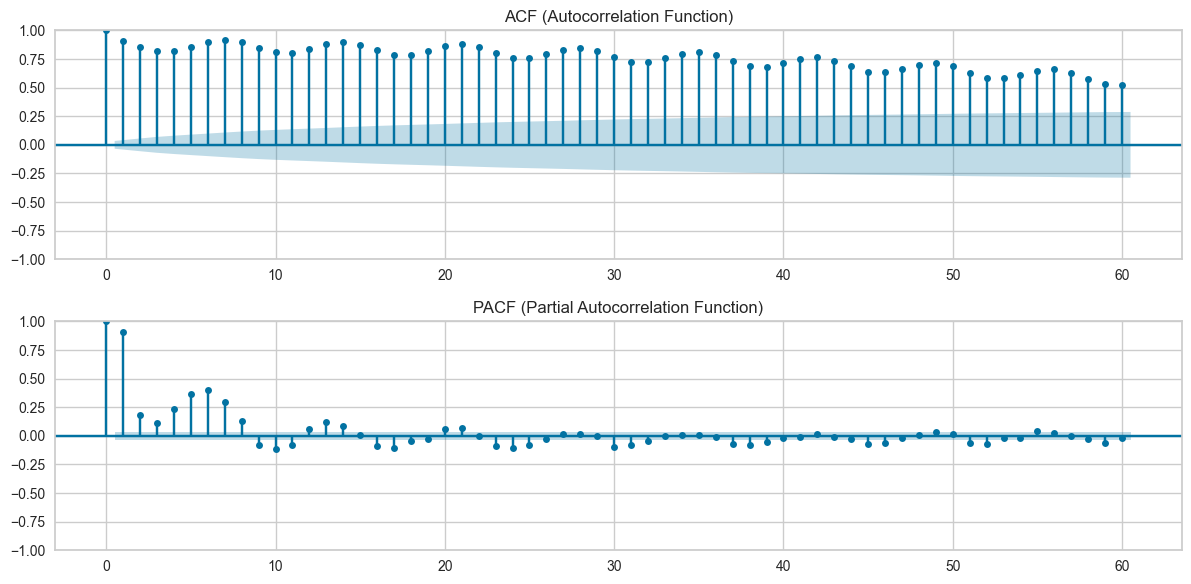

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

plot_acf(daily_total_train.set_index('Date')['number_sold'], ax=ax[0], lags=60)
ax[0].set_title("ACF (Autocorrelation Function)")

plot_pacf(daily_total_train.set_index('Date')['number_sold'], ax=ax[1], lags=60, method='ywm')
# default method - Yule-Walker Modified - Stable and reliable for large lags; works well in stationary rows.
ax[1].set_title("PACF (Partial Autocorrelation Function)")

plt.tight_layout()
plt.show()

- ACF :
    - Almost all lags are well above zero => a typical sign of a trend in the data.
    - Slow decay indicates that the series is non-stationary → likely requires d=1 (takes a linear trend → turns a series into a stationary one)
    - Spikes at lags 7, 14, 21 suggest the presence of weekly seasonality.

- PACF:
    - One or more significant spikes → candidate values for p (autoregressive order).
    - After a lag of ~7, all correlations are already close to zero (noise).

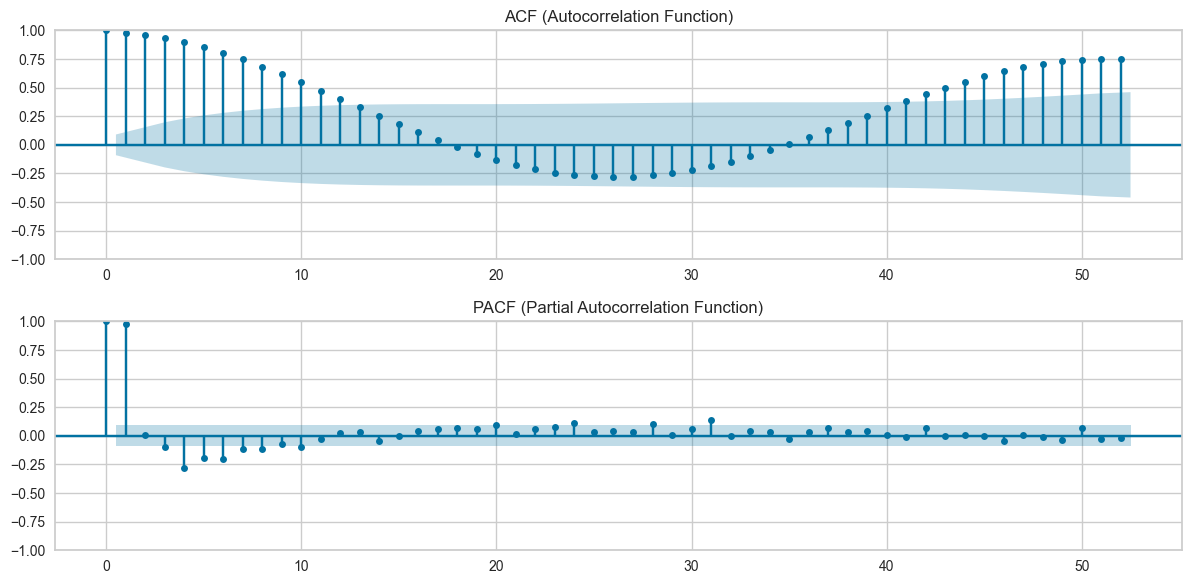

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

plot_acf(weekly_total_train.set_index('week')['number_sold'], ax=ax[0], lags=52)
ax[0].set_title("ACF (Autocorrelation Function)")

plot_pacf(weekly_total_train.set_index('week')['number_sold'], ax=ax[1], lags=52)
ax[1].set_title("PACF (Partial Autocorrelation Function)")

plt.tight_layout()
plt.show()

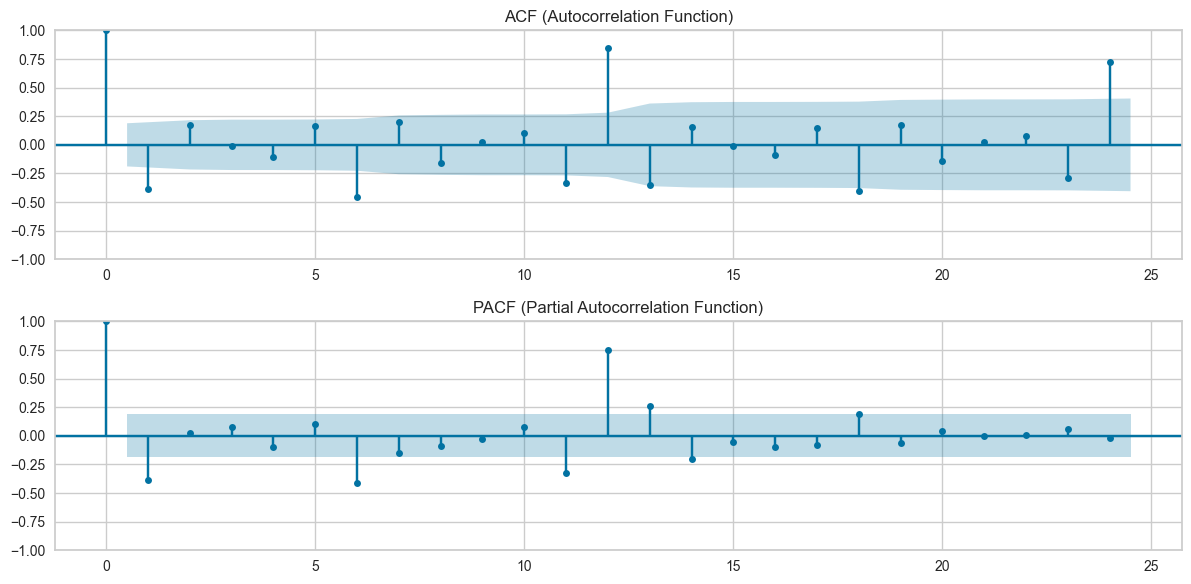

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

plot_acf(monthly_total_train.set_index('month')['number_sold'], ax=ax[0], lags=24)
ax[0].set_title("ACF (Autocorrelation Function)")

plot_pacf(monthly_total_train.set_index('month')['number_sold'], ax=ax[1], lags=24)
ax[1].set_title("PACF (Partial Autocorrelation Function)")

plt.tight_layout()
plt.show()

Can assume these params for different aggregation: 
- Daily data: s=7, d=1
- Weekly data: s=52, d=1, D=1
- Monthly : s=12, d=1, D=0

## feature engineering pipeline for time series

To simplify the modeling process, we use the PyCaret library, which provides an automated machine learning pipeline for time series forecasting. The setup function initializes the forecasting experiment, automatically handling data preprocessing, feature engineering, lag creation, and time-based cross-validation. We specify the forecasting horizon, target column, and time index, and PyCaret prepares the data for model comparison and training.



In [24]:
eda = TSForecastingExperiment()
eda.setup(data=daily_total_train.tail(1000), fh = 7, session_id = 42,  
fold = 5 ,target = 'number_sold', index = 'Date')

- Seasonality has been found — especially pronounced on the 21st
- The series is unstable → PyCaret recommends using d=1 (conventional differentiation)
- Seasonal differentiation (D) is not required → seasonality is stable
- It can be used models that work well with trend + seasonality (ARIMA, ETS, Prophet, AutoARIMA, etc.)

In [25]:
best_model = eda.compare_models(
    include=['arima', 'auto_arima', 'prophet', 'ets', 'naive'],
    sort='MAPE'  
)

as you can see above, the Prophet performed best according to the MAPE metric - this model is the easiest to use, so we'll put it on for now

## Prophet

In [ ]:
daily_total_train_copy = daily_total_train.copy()
daily_total_train_copy = daily_total_train_copy.rename(columns={'Date': 'ds', 'number_sold': 'y'})

model_prophet_daily = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, )
model_prophet_daily.fit(daily_total_train_copy)

model_prophet_daily_future = model_prophet_daily.make_future_dataframe(periods=365)
model_prophet_daily_forecast = model_prophet_daily.predict(model_prophet_daily_future)

In [118]:
fig = plot_forecast_generic(
    y_train=daily_total_train.set_index('Date')['number_sold'],
    y_test=daily_total_test.set_index('Date')['number_sold'],
    forecast_df=model_prophet_daily_forecast,
    model_name="Prophet",
    start_date='2018-10-01'
)
fig.show()


## ARIMA 

In [67]:
df = daily_total_train.copy()
df['month'] = df['Date'].dt.month
df['day_of_year'] = df['Date'].dt.dayofyear
df['sin_year'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['cos_year'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

y_train = df.set_index('Date')['number_sold']
y_test = df.set_index('Date')['number_sold']

X_train_exog = df.set_index('Date')[['sin_year', 'cos_year']]

y_test = daily_total_test.set_index('Date')['number_sold']
X_test_exog = daily_total_test.copy()
X_test_exog['day_of_year'] = X_test_exog['Date'].dt.dayofyear
X_test_exog['sin_year'] = np.sin(2 * np.pi * X_test_exog['day_of_year'] / 365)
X_test_exog['cos_year'] = np.cos(2 * np.pi * X_test_exog['day_of_year'] / 365)
X_test_exog = X_test_exog.set_index('Date')[['sin_year', 'cos_year']]

model = SARIMAX(
    y_train, 
    exog=X_train_exog,
    order=(2, 1, 1), 
    seasonal_order=(0, 1, 2, 7), 
    enforce_stationarity=False, 
    enforce_invertibility=False
)
sarima_result = model.fit(disp=False)

sarima_forecast = sarima_result.get_forecast(steps=len(y_test), exog=X_test_exog)
forecast_mean = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

forecast_sarima_df = pd.DataFrame({
    'y_pred': forecast_mean,
    'lower': conf_int.iloc[:, 0],
    'upper': conf_int.iloc[:, 1]
}, index=y_test.index)

In [68]:
fig = plot_forecast_generic(
    y_train, 
    y_test, 
    forecast_sarima_df, 
    model_name="SARIMA", 
    start_date="2018-10-01"
)
fig.show()

## Linear Regression 

Linear regression may work better because: 
- flexibility of features (lags of any order, sliding windows, rolling statistics, moving average, calendars, holidays, weather labels, etc.)
- ARIMA and Prophet don't handle sudden structural changes well
- very easy to calculate
- the most understandable interpretation for business


In [93]:
df_train = daily_total_train.copy()
df_test = daily_total_test.copy()

df_train['time_idx'] = (df_train['Date'] - df_train['Date'].min()).dt.days
df_test['time_idx'] = (df_test['Date'] - df_train['Date'].min()).dt.days

for df in [df_train, df_test]:
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    # for weekly seasonality
    df['sin_week'] = np.sin(2 * np.pi * df['time_idx'] / 7)
    df['cos_week'] = np.cos(2 * np.pi * df['time_idx'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['time_idx'] / 30)
    df['cos_month'] = np.cos(2 * np.pi * df['time_idx'] / 30)
    # for yearly seasonality
    df['sin_year'] = np.sin(2 * np.pi * df['time_idx'] / 365.25)
    df['cos_year'] = np.cos(2 * np.pi * df['time_idx'] / 365.25)

for lag in [1, 7, 14, 28]:
    df_train[f'lag_{lag}'] = df_train['number_sold'].shift(lag)
    df_test[f'lag_{lag}'] = df_test['number_sold'].shift(lag)

df_train['rolling_mean_7'] = df_train['number_sold'].rolling(7).mean()
df_train['rolling_std_7'] = df_train['number_sold'].rolling(7).std()

df_test['rolling_mean_7'] = df_test['number_sold'].rolling(7).mean()
df_test['rolling_std_7'] = df_test['number_sold'].rolling(7).std()

df_train['is_december'] = (df_train['month'] == 12).astype(int)
df_test['is_december'] = (df_test['month'] == 12).astype(int)

df_train['is_weekend'] = (df_train['dayofweek'] >= 5).astype(int)
df_test['is_weekend'] = (df_test['dayofweek'] >= 5).astype(int)


features = ['time_idx', 'dayofweek', 'month', 'sin_week', 'cos_week', 'sin_month', 'cos_month', 'sin_year', 'cos_year',
            'lag_1','lag_7','lag_14','lag_28','rolling_mean_7','rolling_std_7','is_december', 'is_weekend']

df_train_clean = df_train.dropna(subset=features + ['number_sold'])
df_test_clean = df_test.dropna(subset= features + ['number_sold'])
scaler=StandardScaler()

X_train = scaler.fit_transform(df_train_clean[features])
y_train = df_train_clean['number_sold'].values

X_test = scaler.transform(df_test_clean[features])
y_test = df_test_clean['number_sold'].values


In [96]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)


LinearRegression()

In [97]:
y_pred = model_lr.predict(X_test)

In [101]:
train_pred = model_lr.predict(X_train)
residuals = y_train - train_pred
std_dev = np.std(residuals)

upper = y_pred + 1.96 * std_dev
lower = y_pred - 1.96 * std_dev


In [104]:
forecast_df = pd.DataFrame({
    'y_pred': y_pred,
    'upper': upper,
    'lower': lower
}, index=df_test_clean['Date'])

In [ ]:
fig = plot_forecast_generic(
    y_train=df_train.set_index('Date')['number_sold'],
    y_test=df_test.set_index('Date')['number_sold'],
    forecast_df=forecast_df,
    model_name="Linear Regression",
    start_date='2018-10-01'
)
fig.show()

## LGBMRegressor

LGBMRegressor is an implementation of gradient boosting on decision trees from the LightGBM library, specifically for regression tasks (in our case, forecasting the number of sales).

In [109]:
model_lgb = lgb.LGBMRegressor(n_estimators=500)
model_lgb.fit(X_train, y_train)
y_pred = model_lgb.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 3259, number of used features: 17
[LightGBM] [Info] Start training from score 54663.859466


In [112]:
residuals = y_train - train_pred
std_dev = np.std(residuals)

upper = y_pred + 1.96 * std_dev
lower = y_pred - 1.96 * std_dev

forecast_df = pd.DataFrame({
    'y_pred': y_pred,
    'upper': upper,
    'lower': lower
}, index=df_test_clean['Date'])

In [113]:
fig = plot_forecast_generic(
    y_train=df_train.set_index('Date')['number_sold'],
    y_test=df_test.set_index('Date')['number_sold'],
    forecast_df=forecast_df,
    model_name="LGBMRegressor",
    start_date='2018-10-01'
)
fig.show()

## LSTM 

a type of recurrent neural network (RNN), especially good for modeling long—term dependencies in time series.

In [115]:
df_train = daily_total_train.copy()
df_test = daily_total_test.copy()

df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

df_full = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

data = df_full['number_sold'].values.reshape(-1, 1)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30 
X, y = create_sequences(data_scaled, seq_length)

train_size = len(df_train) - seq_length
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='tanh', input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

y_pred_scaled = model_lstm.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_orig = scaler.inverse_transform(y_test)



Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0364 - val_loss: 0.0042
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_lo

In [116]:
residuals = y_test_orig.flatten() - y_pred.flatten()
std_dev = np.std(residuals)

upper = y_pred.flatten() + 1.96 * std_dev
lower = y_pred.flatten() - 1.96 * std_dev

forecast_df = pd.DataFrame({
    'y_pred': y_pred.flatten(),
    'upper': upper,
    'lower': lower
}, index=df_test['Date'])


In [117]:
fig = plot_forecast_generic(
    y_train=df_train.set_index('Date')['number_sold'],
    y_test=df_test.set_index('Date')['number_sold'],
    forecast_df=forecast_df,
    model_name="LSTM",
    start_date='2018-10-01'
)
fig.show()

Although linear regression won according to MAPE, in the framework of this work, for simplicity, we will leave the Prophet

# Grouped data 

In [ ]:
plot_grouped_data(daily_store_train,
                  daily_store_test,
                  'store',
                  description = 'Store' )

Dropdown(description='Store:', layout=Layout(width='300px'), options=(0, 1, 2, 3, 4, 5, 6), value=0)

Output()

In [ ]:
plot_grouped_data(daily_product_train,
                  daily_product_test,
                  'product',
                  description = 'Product' )

Dropdown(description='Product:', layout=Layout(width='300px'), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0…

Output()

In [ ]:
plot_grouped_data(monthly_store_train,
                  monthly_store_test,
                  'store',
                  description = 'Store' )

Dropdown(description='Store:', layout=Layout(width='300px'), options=(0, 1, 2, 3, 4, 5, 6), value=0)

Output()

In [201]:
plot_grouped_data(monthly_product_train,
                  monthly_product_test,
                  'product',
                  description = 'Product' )

Dropdown(description='Product:', layout=Layout(width='300px'), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0…

Output()

# Save data 

In [ ]:
path='data/'
path_forecasts = 'forecasts/'

In [ ]:
monthly_total_train, monthly_total_test, \
monthly_product_train, monthly_product_test, \
monthly_store_train, monthly_store_test = [
    df.rename(columns={'month': 'Date'}) 
    for df in [
        monthly_total_train,
        monthly_total_test,
        monthly_product_train,
        monthly_product_test,
        monthly_store_train,
        monthly_store_test
    ]
]

In [ ]:
daily_total_train.to_csv(f'{path}df_daily_total_train.csv')
daily_total_test.to_csv(f'{path}df_daily_total_test.csv')

monthly_total_train.to_csv(f'{path}df_monthly_total_train.csv')
monthly_total_test.to_csv(f'{path}df_monthly_total_test.csv')

daily_product_train.to_csv(f'{path}df_daily_product_train.csv')
daily_product_test.to_csv(f'{path}df_daily_product_test.csv')

monthly_product_train.to_csv(f'{path}df_monthly_product_train.csv')
monthly_product_test.to_csv(f'{path}df_monthly_product_test.csv')

daily_store_train.to_csv(f'{path}df_daily_store_train.csv')
daily_store_test.to_csv(f'{path}df_daily_store_test.csv')

monthly_store_train.to_csv(f'{path}df_monthly_store_train.csv')
monthly_store_test.to_csv(f'{path}df_monthly_store_test.csv')

In [ ]:
level = "store"  
granularity = "daily"  
forecast_period = 365  
forecast_freq = "D" if granularity == "daily" else "MS"

df = pd.read_csv(f"data/df_{granularity}_{level}_train.csv", parse_dates=["Date"])
df = df.rename(columns={"Date": "ds", "number_sold": "y"})


entity_col = "store" if level == "store" else "product"
unique_ids = df[entity_col].unique()

# create and save a folder 
os.makedirs("forecasts", exist_ok=True)
save_path = f"forecasts/prophet_{granularity}_{level}.pkl"


forecasts = {}


for eid in tqdm(unique_ids, desc=f"Forecasting {level}s"):
    df_entity = df[df[entity_col] == eid].copy()

    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.fit(df_entity)

    future = model.make_future_dataframe(periods=forecast_period, freq=forecast_freq)
    forecast = model.predict(future)

    forecasts[eid] = forecast


joblib.dump(forecasts, save_path)
print(f" Saved {len(forecasts)} forecasts to {save_path}")


Forecasting stores:   0%|          | 0/7 [00:00<?, ?it/s]

 Saved 7 forecasts to forecasts/prophet_daily_store.pkl


In [ ]:
levels = ["total", "store", "product"]
frequencies = ["daily", "monthly"]


forecast_periods = {"daily": 365, "monthly": 12}
forecast_freqs = {"daily": "D", "monthly": "MS"}


os.makedirs("forecasts", exist_ok=True)

for level in levels:
    for gran in frequencies:
        print(f"\nForecasting: {level.upper()} — {gran.upper()}")
        path = f"data/df_{gran}_{level}_train.csv"
        try:
            df = pd.read_csv(path, parse_dates=["Date"])
        except FileNotFoundError:
            print(f" File isn't found: {path}")
            continue

        df = df.rename(columns={"Date": "ds", "number_sold": "y"})
        forecast_dict = {}

        
        if level == "total":
            model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
            model.fit(df)
            future = model.make_future_dataframe(periods=forecast_periods[gran], freq=forecast_freqs[gran])
            forecast = model.predict(future)
            joblib.dump(forecast, f"forecasts/prophet_{gran}_{level}.pkl")
            print(f"Saved: prophet_{gran}_{level}.pkl")
        else:
            entity_col = "store" if level == "store" else "product"
            for entity_id in tqdm(df[entity_col].unique(), desc=f"Forecasting {level}s"):
                df_entity = df[df[entity_col] == entity_id].copy()

                model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
                model.fit(df_entity)
                future = model.make_future_dataframe(periods=forecast_periods[gran], freq=forecast_freqs[gran])
                forecast = model.predict(future)

                forecast_dict[entity_id] = forecast

            joblib.dump(forecast_dict, f"forecasts/prophet_{gran}_{level}.pkl")
            print(f"Saved: prophet_{gran}_{level}.pkl  ({len(forecast_dict)} objects)")





Forecasting: TOTAL — DAILY
Saved: prophet_daily_total.pkl

Forecasting: TOTAL — MONTHLY
Saved: prophet_monthly_total.pkl

Forecasting: STORE — DAILY


Forecasting stores:   0%|          | 0/7 [00:00<?, ?it/s]

Saved: prophet_daily_store.pkl  (7 objects)

Forecasting: STORE — MONTHLY


Forecasting stores:   0%|          | 0/7 [00:00<?, ?it/s]

Saved: prophet_monthly_store.pkl  (7 objects)

Forecasting: PRODUCT — DAILY


Forecasting products:   0%|          | 0/10 [00:00<?, ?it/s]

Saved: prophet_daily_product.pkl  (10 objects)

Forecasting: PRODUCT — MONTHLY


Forecasting products:   0%|          | 0/10 [00:00<?, ?it/s]

Saved: prophet_monthly_product.pkl  (10 objects)


# Anomaly Detection Comparison 

We compare different approaches for detecting anomalies in time series forecasts:

- Prophet Confidence Interval: We flag anomalies when the actual values fall outside the model's predicted uncertainty bounds (typically 80%).

- STL + Z-Score Method: We decompose the time series into trend, seasonality, and residuals using STL (Seasonal-Trend decomposition). Anomalies are detected when the residuals exceed a Z-score threshold (e.g. |Z| > 3).

- Isolation Forest: A machine learning-based approach that detects anomalies by identifying data points that are isolated from the rest of the distribution. It operates well on non-Gaussian data and does not assume any specific distribution.

The purpose of this comparison is to understand how different anomaly detection strategies behave on the same forecast, evaluate their sensitivity, and identify outliers more robustly across different time series settings.

In [246]:
from statsmodels.tsa.seasonal import STL

In [291]:
from sklearn.ensemble import IsolationForest


def compare_anomaly_methods(y_test, forecast_df, z_thresh=3.0, contamination=0.01):
    forecast_df = forecast_df.copy()
    if 'ds' in forecast_df.columns:
        forecast_df.set_index('ds', inplace=True)

    forecast_df = forecast_df.loc[y_test.index]
    forecast_df = forecast_df.dropna(subset=['yhat', 'yhat_upper', 'yhat_lower'])

    y_pred = forecast_df['yhat'] if 'yhat' in forecast_df else forecast_df['y_pred']

    # Prophet CI-based anomalies
    prophet_anomalies = (y_test < forecast_df['yhat_lower']) | (y_test > forecast_df['yhat_upper'])

    # STL + Z-score
    series = y_test
    stl = STL(series, period=7)
    result = stl.fit()
    resid = result.resid
    z_scores = (resid - resid.mean()) / resid.std()
    stl_anomalies = np.abs(z_scores) > z_thresh

    # Isolation Forest
    df_if = pd.DataFrame({"y": series.values}, index=series.index)
    model = IsolationForest(contamination=contamination, random_state=42)
    df_if["anomaly"] = model.fit_predict(df_if[["y"]])
    iso_anomalies = df_if["anomaly"] == -1


    # Print counts
    print(f"Prophet anomalies: {prophet_anomalies.sum()}")
    print(f"STL + Z anomalies: {stl_anomalies.sum()}")
    print(f"Isolation Forest anomalies: {iso_anomalies.sum()}")


    # Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=series.index, y=series.values, name="Actual", line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=series.index[prophet_anomalies], y=series[prophet_anomalies], mode='markers', name="Prophet CI", marker=dict(color='orange', symbol='x', size=8)))
    fig.add_trace(go.Scatter(x=series.index[stl_anomalies], y=series[stl_anomalies], mode='markers', name="STL + Z", marker=dict(color='red', symbol='circle', size=7)))
    fig.add_trace(go.Scatter(x=series.index[iso_anomalies], y=series[iso_anomalies], mode='markers', name="Isolation Forest", marker=dict(color='purple', symbol='diamond', size=7)))
    fig.add_trace(go.Scatter(
    x=forecast_df.index, y=forecast_df["yhat_upper"],
    mode='lines',
    name='Upper CI',
    line=dict(color='lightblue', dash='dash'),
    showlegend=False
    ))

    fig.add_trace(go.Scatter(
    x=forecast_df.index, y=forecast_df["yhat_lower"],
    mode='lines',
    name='Lower CI',
    line=dict(color='lightblue', dash='dash'),
    fill='tonexty',
    fillcolor='rgba(173, 216, 230, 0.3)',  
    showlegend=True
    ))

    fig.update_layout(title="Anomaly Detection Comparison", template="plotly_white", height=500)

    fig.show()

In [292]:
compare_anomaly_methods(
    y_test=daily_total_test.set_index("Date")["number_sold"],
    forecast_df=joblib.load("forecasts/prophet_daily_total.pkl"),
    z_thresh = 1.28 #
)

Prophet anomalies: 88
STL + Z anomalies: 77
Isolation Forest anomalies: 4


In [ ]:
compare_anomaly_methods(
    y_test=daily_total_test.set_index("Date")["number_sold"],
    forecast_df=joblib.load("forecasts/prophet_daily_total.pkl")
)

In [302]:
def compare_anomaly_grouped(data_test, 
                            forecast_dict,
                            group_col="store",
                             description="Store",
                             z_thresh = 3,
                             contamination = 0.01):
    
    feature_selector = widgets.Dropdown(
        options=sorted(data_test[group_col].unique()),
        description=f"{description}:",
        layout=widgets.Layout(width="300px")
    )
    output = widgets.Output()

    def plot_anomalies_for_id(group_id):
        y_test = data_test[data_test[group_col] == group_id].copy()
        y_test = y_test.set_index("Date")["number_sold"]

        forecast_df = forecast_dict.get(group_id)
        if forecast_df is None:
            print(f"No forecast for {description} {group_id}")
            return

        compare_anomaly_methods(y_test=y_test, forecast_df=forecast_df, z_thresh = z_thresh, 
                                contamination = contamination)

    def on_change(change):
        if change["type"] == "change" and change["name"] == "value":
            with output:
                clear_output(wait=True)
                plot_anomalies_for_id(change["new"])

    feature_selector.observe(on_change)

    display(feature_selector, output)
    with output:
        plot_anomalies_for_id(feature_selector.value)

In [303]:
forecast_dict = joblib.load("forecasts/prophet_daily_store.pkl")
compare_anomaly_grouped(daily_store_test, forecast_dict, group_col="store", 
                        description="Store",
                        z_thresh = 2, contamination = 0.05)


Dropdown(description='Store:', layout=Layout(width='300px'), options=(0, 1, 2, 3, 4, 5, 6), value=0)

Output()

In [295]:
forecast_dict = joblib.load("forecasts/prophet_daily_product.pkl")
compare_anomaly_grouped(daily_product_test, forecast_dict, group_col="product", description="Product")


Dropdown(description='Product:', layout=Layout(width='300px'), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0…

Output()

In [286]:
compare_anomaly_methods(
    y_test=daily_total_test.set_index("Date")["number_sold"],
    forecast_df=joblib.load("forecasts/prophet_daily_total.pkl"),
    z_thresh = 2,
    contamination=0.05
)

Prophet anomalies: 88
STL + Z anomalies: 17
Isolation Forest anomalies: 18
